# Stochastic amplified variance gradient experiments

Minimize the function $$f_{\gamma}(x) = \frac{1}{2} (x-\gamma)^T H (x-\gamma) - \frac{1}{2} Tr(H)$$, where $\gamma \sim \mathcal{N}(0,I)$.
The gradient is given by $$\nabla f_{\gamma}(x) = H(x - \gamma).$$ The stochastic gradient descent iterates are given by $$x_{k+1} = x_k - \eta H(x_k - \gamma).$$


In [1]:
import jax.numpy as jnp
import jax.scipy.linalg as linalg
from jax import random
from noisy_gradient_descent import *
from gradient_descent import gradient_descent_update
from network import *
from stochastic_variance_amplified_gradient import *
from tqdm.auto import tqdm

jax.config.update('jax_platform_name', 'cpu')


/home/jonathan/uni/thesis/code/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 4
NUMBER_OF_VARIABLES = 3
INITIAL_VALUE_NOISE_SCALING = 5.0
FINAL_TIME = 2.0
LEARNING_RATE = 0.001

number_of_time_points = int(FINAL_TIME / LEARNING_RATE)
key = random.PRNGKey(SEED)
# key, subkey = random.split(key)
# random_normal_matrix = random.normal(
#     subkey, (NUMBER_OF_VARIABLES, NUMBER_OF_VARIABLES))
# H = random_normal_matrix.T @ random_normal_matrix
H = jnp.identity(NUMBER_OF_VARIABLES)
key, subkey = random.split(key)
x_0 = INITIAL_VALUE_NOISE_SCALING * random.normal(subkey,
                                                  (NUMBER_OF_VARIABLES,))


In [3]:
def loss(x, gamma, H):
    return 0.5 * (x - gamma).T @ H @ (x - gamma) - 0.5 * jnp.trace(H)

@jit
@partial(jax.vmap, in_axes=(0, None, None, None))
def expected_first_order_loss(time, initial_value, H, learning_rate):
    decay_term = 0.5 * initial_value.T @ H @ linalg.expm(
        -2.0 * time * H) @ initial_value
    # Eigenvalue in ascending order
    eigenvalues, _ = linalg.eigh(H)
    noise_term = 0.25 * learning_rate * jnp.sum(
        jnp.square(eigenvalues) * (1 - jnp.exp(-2.0 * time * eigenvalues)))
    return decay_term + noise_term


@jit
@partial(jax.vmap, in_axes=(0, None, None, None))
def expected_second_order_loss(time, initial_value, H, learning_rate):
    decay_term = 0.5 * initial_value.T @ H @ linalg.expm(
        -(2 * H + learning_rate * H @ H) * time) @ initial_value
    eigenvalues, _ = linalg.eigh(H)
    noise_term = 0.5 * learning_rate * jnp.sum(
        jnp.square(eigenvalues) / (2 + learning_rate * eigenvalues) *
        (1 - jnp.exp(-eigenvalues *
                     (learning_rate * eigenvalues + 2.0) * time)))
    return decay_term + noise_term


In [4]:
time = jnp.linspace(0.0, FINAL_TIME, number_of_time_points)
expected_loss_value = expected_second_order_loss(time, x_0, H, LEARNING_RATE)
test = 0.5 * jnp.exp(-(2 + LEARNING_RATE) * time) * jnp.inner(
    x_0, x_0) + 0.5 * LEARNING_RATE * NUMBER_OF_VARIABLES * 1 / (
        2 + LEARNING_RATE) * (1 - jnp.exp(-(2 + LEARNING_RATE) * time))
print(expected_loss_value)
print(test)


[94.66049   94.47117   94.28223   ...  1.7379783  1.7345042  1.7310381]
[94.66049   94.471176  94.28223   ...  1.7379811  1.7345065  1.7310394]


In [78]:
print(jax.grad(loss)(x_0, jnp.zeros(3,), H))
print(x_0)

[-8.527506 -7.255669  7.997368]
[-8.527506 -7.255669  7.997368]


In [5]:
x = jnp.ones((1,4)) @ jnp.identity(4) @ jnp.ones((4,1))
x.shape

(1, 1)

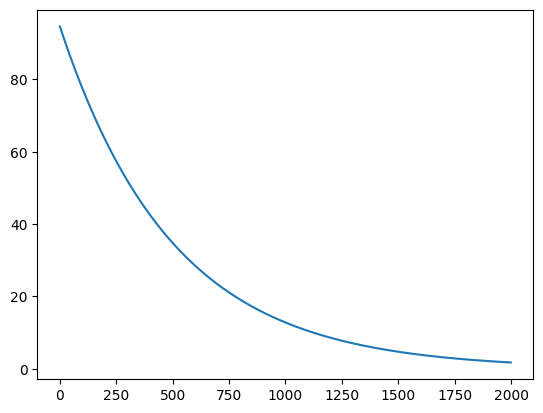

In [6]:
plt.plot(expected_loss_value.reshape((-1,)))

In [7]:
# # @jit
# @partial(jax.vmap, in_axes=(1, None, 1, None))
# def stochastic_gradient_update(x, H, gamma, learning_rate):
#     value, gradient = jax.value_and_grad(loss)(x, gamma, H)
#     updated_x = x - learning_rate * gradient
#     return value, updated_x

# Average sampled loss with SGD


In [8]:
# SAMPLES = 100000
# LEARNING_RATES = [0.01, 0.005,0.0001]

# for learning_rate in LEARNING_RATES:
#     expected = []
#     max_iterations = int(FINAL_TIME / learning_rate)
#     time = jnp.linspace(0.0, FINAL_TIME, max_iterations)
#     current_time = 0.0
#     average = []
#     x = jnp.repeat(x_0[:, jnp.newaxis], SAMPLES, axis=1).T
#     current_time = 0
#     for _ in range(max_iterations):
#         key_array = random.split(key, SAMPLES + 1)
#         key = key_array[-1]
#         value, x = stochastic_gradient_update(key_array[:-1], x, H,
#                                               learning_rate)
#         average.append(
#             jnp.average(value))
#         expected.append(expected_first_order_loss(current_time, x_0, H, learning_rate))
#         current_time += learning_rate
#     plt.plot(time, jnp.abs(jnp.array(average) - jnp.array(expected)), label=f'lr={learning_rate}')
#     plt.legend()
# plt.savefig('/home/jonathan/forest/images/large_error_between_expected_and_sampled.png')


# Recreating weak order 1 plot


In [11]:
@jit
@partial(jax.vmap, in_axes=(0, None, 0, None))
def stochastic_gradient_update(x, H, gamma, learning_rate):
    gradient = jax.grad(loss)(x, gamma, H)
    updated_x = x - learning_rate * gradient
    value = 0.5 * updated_x.T @ H @ updated_x
    return value, updated_x

SAMPLES = 1000000
LEARNING_RATES = 2.0**jnp.arange(0, -9, -1)
sampled_values = [[] for i in range(len(LEARNING_RATES))]
for index, learning_rate in enumerate(LEARNING_RATES):
    max_iterations = int(FINAL_TIME / learning_rate)
    x = jnp.tile(x_0, (SAMPLES,1))
    for _ in tqdm(range(max_iterations)):
        key, subkey = random.split(key)
        normal_noise = random.normal(subkey, (SAMPLES, NUMBER_OF_VARIABLES))
        value, x = stochastic_gradient_update(x, H, normal_noise,
                                              learning_rate)
        sampled_values[index].append(jnp.average(value))

100%|██████████| 512/512 [00:41<00:00, 12.33it/s]


In [12]:
first_order_error = []
second_order_error = []
for learning_rate, sampled_value in zip(LEARNING_RATES, sampled_values):
    time = jnp.arange(0.0, FINAL_TIME, learning_rate) + learning_rate
    expected_first_order_loss_value = expected_first_order_loss(
        time, x_0, H, learning_rate)
    expected_second_order_loss_value = expected_second_order_loss(
        time, x_0, H, learning_rate)
    first_order_error.append(jnp.max(jnp.abs(jnp.array(sampled_value) - expected_first_order_loss_value)))
    second_order_error.append(
        jnp.max(jnp.abs(jnp.array(sampled_value) - expected_second_order_loss_value)))



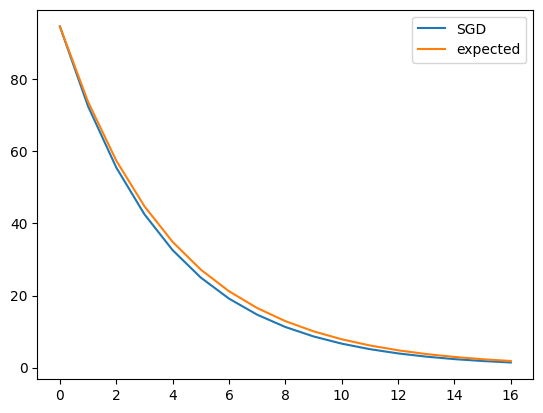

In [6]:
for i, learning_rate in enumerate(LEARNING_RATES):
    if i == 2:
        values = jnp.array([0.5 * x_0.T @ H @ x_0] + sampled_values[i])
        plt.plot(values, label = "SGD")
        time = jnp.arange(0.0, FINAL_TIME + learning_rate,
                          learning_rate)
        expected_first_order_loss_value = expected_first_order_loss(
            time, x_0, H, learning_rate)
        plt.plot(expected_first_order_loss_value, label = 'expected')
plt.legend()
# plt.savefig('/home/jonathan/forest/images/sgd_weird_behavior.png')

In [82]:
@partial(jax.vmap, in_axes = 0)
def loss_function(x):
    return 0.5 * x.T @ H @ x

@partial(jax.vmap, in_axes=(0, None, 0))
def update(x, learning_rate, noise):
    return x - learning_rate * jax.grad(loss)(x, noise, H)
noise = random.normal(random.PRNGKey(3), (10000,3))
y = jnp.tile(x_0, (10000, 1))
print(jnp.average(loss_function(y)))
x_1 = update(y, 0.125, noise)
print(jnp.average(loss_function(x_1)))
x_1 = update(y, 0.125, jnp.zeros((10000,3)))
print(jnp.average(loss_function(x_1)))


94.660484
72.50637
72.47444


In [14]:
A = jnp.column_stack(
    (jnp.log(jnp.array(LEARNING_RATES)), jnp.ones((len(LEARNING_RATES), ))))
log_first_order_error = jnp.log(jnp.array(first_order_error))
log_second_order_error = jnp.log(jnp.array(second_order_error))
first_order_slope, _, _, _ = jnp.linalg.lstsq(A, log_first_order_error)
second_order_slope, _, _, _ = jnp.linalg.lstsq(A, log_second_order_error)
print(first_order_slope)
print(second_order_slope)

[0.9857581 2.8256495]
[1.7293952 1.8034126]


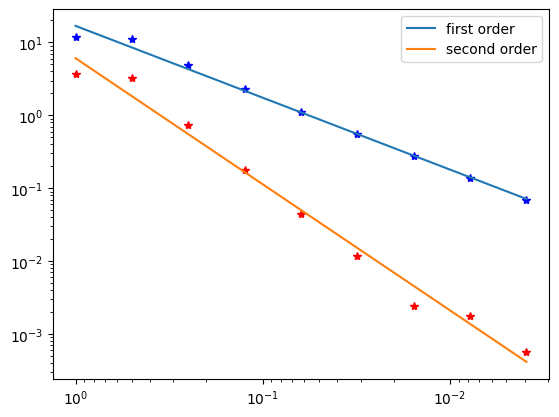

In [15]:
for learning_rate, error in zip(LEARNING_RATES, first_order_error):
    plt.plot(learning_rate,
             error,
             'b*')
for learning_rate, error in zip(LEARNING_RATES, second_order_error):
    plt.plot(learning_rate,
             error,
             'r*')
t = jnp.linspace(LEARNING_RATES[-1], LEARNING_RATES[0], 1000)
y = jnp.exp(first_order_slope[1]) * t**first_order_slope[0]
plt.plot(t, y, '-', label='first order')
y = jnp.exp(second_order_slope[1]) * t**second_order_slope[0]
plt.plot(t, y, '-', label='second order')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig('/home/jonathan/forest/images/weak_order_2_SGD_fixed.png')

In [17]:
def objective(x, gamma, Q, D):
    return 0.5 * (Q.T @ x).T @ (D + jnp.diag(gamma)) @ (Q.T @ x)

In [18]:
@partial(jax.vmap, in_axes = (0, None, None, None))
def expected_objective(time, initial_value, learning_rate, H):
    return 0.5 * jnp.exp(learning_rate * time) * initial_value.T @ H @ linalg.expm(-2 * H * time) @ initial_value

In [22]:
@jit
@partial(jax.vmap, in_axes=(0, 0, None, None, None))
def stochastic_gradient_update(x, gamma, Q, D, learning_rate):
    gradient = jax.grad(objective)(x, gamma, Q, D)
    updated_x = x - learning_rate * gradient
    value = 0.5 * updated_x.T @ Q @ D @ Q.T @ x
    return value, updated_x

SAMPLES = 10000000
LEARNING_RATES = 2.0**jnp.arange(-2, -8, -1)
sampled_values = [[] for i in range(len(LEARNING_RATES))]
for index, learning_rate in enumerate(LEARNING_RATES):
    max_iterations = int(FINAL_TIME / learning_rate)
    x = jnp.tile(x_0, (SAMPLES, 1))
    for _ in tqdm(range(max_iterations)):
        key, subkey = random.split(key)
        normal_noise = random.normal(subkey, (SAMPLES, NUMBER_OF_VARIABLES))
        value, x = stochastic_gradient_update(x, normal_noise, H, H,
                                              learning_rate)
        sampled_values[index].append(jnp.average(value))

100%|██████████| 256/256 [05:43<00:00,  1.34s/it]


In [20]:
first_order_error = []
for learning_rate, sampled_value in zip(LEARNING_RATES, sampled_values):
    time = jnp.arange(0.0, FINAL_TIME, learning_rate) + learning_rate
    expected_first_order_loss_value = expected_objective(
        time, x_0, learning_rate, H)
    first_order_error.append(
        jnp.max(
            jnp.abs(
                jnp.array(sampled_value) - expected_first_order_loss_value)))
A = jnp.column_stack(
    (jnp.log(jnp.array(LEARNING_RATES)), jnp.ones((len(LEARNING_RATES), ))))
log_first_order_error = jnp.log(jnp.array(first_order_error))
first_order_slope, _, _, _ = jnp.linalg.lstsq(A, log_first_order_error)
print(first_order_slope)


[0.77703714 3.5831947 ]


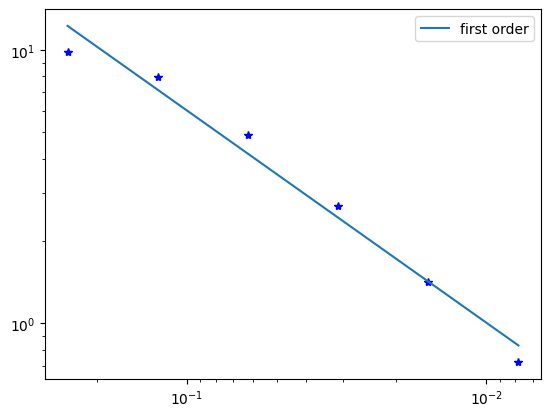

In [21]:
for learning_rate, error in zip(LEARNING_RATES, first_order_error):
    plt.plot(learning_rate, error, 'b*')
t = jnp.linspace(LEARNING_RATES[-1], LEARNING_RATES[0], 1000)
y = jnp.exp(first_order_slope[1]) * t**first_order_slope[0]
plt.plot(t, y, '-', label='first order')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xscale('log')
plt.legend()